In [96]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import shap

import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
c_df = pd.read_csv('/Users/evelynjohnson/Desktop/METIS/Classification/project/classification_df.csv', index_col=0)

In [12]:
c_df.head();

In [16]:
y = c_df['ENERGY STAR Certification - Eligibility']
X = c_df.drop('ENERGY STAR Certification - Eligibility', axis=1).copy()
X.head()

,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Occupancy,Metered Areas (Energy),Metered Areas (Water),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Energy Use (kBtu),Weather Normalized Site Electricity Intensity (kWh/ft²),...,Parking - Partially Enclosed Parking Garage Size (ft²),Property GFA - Calculated (Buildings and Parking) (ft²),Property GFA - Calculated (Buildings) (ft²),Property GFA - Calculated (Parking) (ft²),Water Use (All Water Sources) (kgal),Indoor Water Use (All Water Sources) (kgal),Municipally Supplied Potable Water - Mixed Indoor/Outdoor Use (kgal),Municipally Supplied Potable Water - Total Use (All Meter Types) (kgal),Municipally Supplied Potable Water - Indoor Use (kgal),na_sum
48,375698.0,369742.0,2063.0,1988,95,1.0,1.0,46.7,34986847.2,11.3,...,0.0,749338.0,749338.0,0.0,18233.10,3828.1,18233.1,18233.1,3827.95,16
70,814289.0,39590.0,37681.0,2000,100,1.0,1.0,83.4,74041284.0,6.7,...,0.0,927469.0,887879.0,39590.0,3822.15,3828.1,0.0,3822.5,3827.95,13
1095,401516.0,22500.0,20335.0,2008,100,1.0,1.0,105.7,48386656.7,9.0,...,0.0,472487.0,457771.0,14716.0,13379.80,13379.8,0.0,13379.8,13379.80,9
1097,362939.0,9800.0,1400.0,2003,55,1.0,1.0,92.4,33660883.6,7.5,...,0.0,374139.0,364339.0,9800.0,10194.50,10194.5,0.0,10194.5,10194.50,7
1098,269610.0,14901.0,14400.0,2000,100,1.0,1.0,100.8,28676114.1,11.6,...,0.0,298911.0,284511.0,14400.0,10789.20,10789.2,0.0,10789.2,10789.20,9


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=42)

In [56]:
type(y_train)

pandas.core.series.Series

In [62]:
y_array_tr = y_train.to_numpy()
y_array_te = y_test.to_numpy()

In [79]:
def evaluate(model_name, train_pred, train_prob, test_pred, test_prob):
    
    train_eval = {}
    train_eval['Recall'] = recall_score(y_array_tr, train_pred)
    train_eval['Precision'] = precision_score(y_array_tr, train_pred)
    train_eval['Auc Roc'] = roc_auc_score(y_array_tr, train_prob)
    
    test_eval = {}
    test_eval['Recall'] = recall_score(y_array_te, test_pred)
    test_eval['Precision'] = precision_score(y_array_te, test_pred)
    test_eval['Auc Roc'] = roc_auc_score(y_array_te, test_prob)
    
    for metric in ['Recall', 'Precision', 'Auc Roc']:
        print(f'{metric} Train: {train_eval[metric]}, Test: {test_eval[metric]}')
        
    fpr, tpr, thresholds = roc_curve(y_test, test_prob)
    plt.plot([0,1], [0,1], linestyle='--', label='Baseline')
    plt.plot(fpr, tpr, marker='.', label= model_name)
    plt.title('ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

# Decision Tree Model

In [25]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 1949 nodes with maximum depth 28.


In [73]:
dt_prob_tr = tree.predict_proba(X_train)[:,1]
dt_prob_te = tree.predict_proba(X_test)[:,1]

dt_pred_tr = tree.predict(X_train)
dt_pred_te = tree.predict(X_test)

In [71]:
np.reshape(dt_prob_tr

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Recall Train: 0.9025585193249864, Test: 0.7387580299785867
Precision Train: 0.9077470572132493, Test: 0.7427341227125942
Auc Roc Train: 0.9357278060399736, Test: 0.8250211827695457


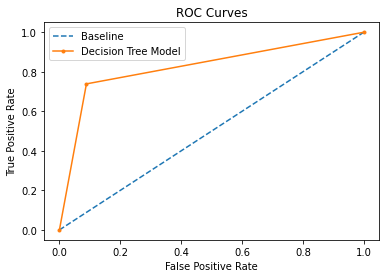

In [80]:
evaluate('Decision Tree Model', dt_pred_tr, dt_prob_tr, dt_pred_te, dt_prob_te)

# Random Forest

In [86]:
rf_model = RandomForestClassifier(n_estimators=100, 
                               random_state=42, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


RandomForestClassifier(max_features='sqrt', n_jobs=-1, random_state=42,
                       verbose=1)

In [88]:
n_nodes = []
max_depths = []

for tree in rf_model.estimators_:
    n_nodes.append(tree.tree_.node_count)
    max_depths.append(tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 1987
Average maximum depth 25


In [89]:
rf_pred_tr = rf_model.predict(X_train)
rf_prob_tr = rf_model.predict_proba(X_train)[:, 1]

rf_pred_te = rf_model.predict(X_test)
rf_prob_te = rf_model.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Recall Train: 1.0, Test: 0.8179871520342612
Precision Train: 1.0, Test: 0.8652321630804077
Auc Roc Train: 1.0, Test: 0.9715185144559486


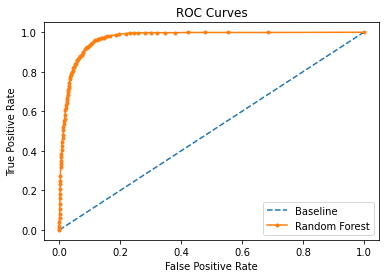

In [90]:
evaluate('Random Forest', rf_pred_tr, rf_prob_tr, rf_pred_te, rf_prob_te)

In [91]:
cm = confusion_matrix(y_test, rf_pred_te)
cm

array([[2575,  119],
       [ 170,  764]])

In [92]:
rf_feature_importance = pd.DataFrame({'feature': X.columns,
                   'importance': rf_model.feature_importances_}).\
                    sort_values('importance', ascending = False)
rf_feature_importance.head(10)

,feature,importance
11,Weather Normalized Source EUI (kBtu/ft²),0.159654
25,Total GHG Emissions Intensity (kgCO2e/ft²),0.087613
7,Weather Normalized Site EUI (kBtu/ft²),0.065239
40,Multifamily Housing - Number of Bedrooms Densi...,0.062193
26,Direct GHG Emissions Intensity (kgCO2e/ft²),0.045646
39,Multifamily Housing - Number of Bedrooms,0.038173
44,Multifamily Housing - Total Number of Resident...,0.031279
9,Weather Normalized Site Electricity Intensity ...,0.029131
48,Multifamily Housing - Number of Residential Li...,0.028396
29,Indirect GHG Emissions Intensity (kgCO2e/ft²),0.027316


In [ ]:
sns.set_color_codes("pastel")
sns.barplot(x="importance", y="feature", data=re_feature_importance,
            label="Feature Importance", color="b")
sns.despine(left=True, bottom=True)

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X)

# Bernoulli Naive Bayes

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
dc = DummyClassifier(strategy='stratified')  
dc.fit(X_train, y_train)
dc.score(X_test, y_test)

0.6201764057331863

In [21]:
nb = BernoulliNB()
nb.fit(X_train,y_train)
nb.score(X_test,y_test)

0.7368614479970599

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, nb.predict(X_test))

array([[3928,  104],
       [1328,   82]])